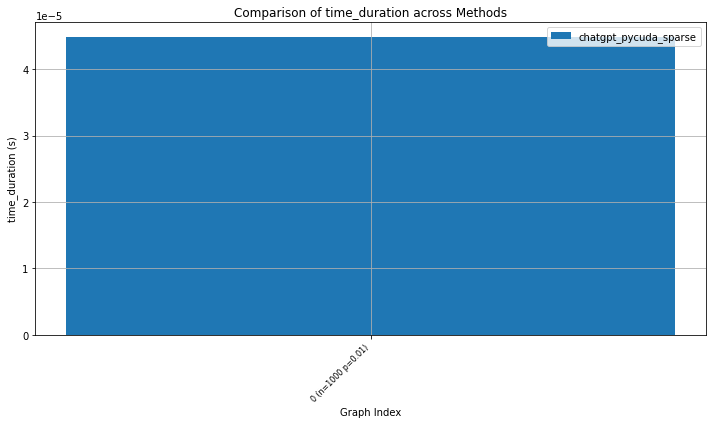

In [6]:
import json
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


# Load JSON report data
def load_report(filename):
    with open(filename, "r") as f:
        return json.load(f)


# Extract metric values for each method for a specific metric
def extract_metric_data(data, metric_name, nvtx="main"):
    unit = None
    metric_data = defaultdict(dict)
    for method, graphs in data.items():
        for graph_index, graph_details in graphs.items():
            # Ensure the metric exists in the current graph's metrics
            if (
                "metrics" in graph_details
                and nvtx in graph_details["metrics"]
                and metric_name in graph_details["metrics"][nvtx]
            ):
                value = graph_details["metrics"][nvtx][metric_name]["value"]
                unit = graph_details["metrics"][nvtx][metric_name]["unit"]
                metric_data[graph_index][method] = value
    return metric_data, unit


# Plot metric comparison as bar chart
def plot_metric_comparison(data, metric_name, save_path):
    metric_data, unit = extract_metric_data(data, metric_name)

    # include num_nodes and sparsity in the graph labels
    graph_properties = {
        graph_index: (
            graph_data["graph_name"],
            graph_data["graph_type"],
            graph_data["num_nodes"],
            graph_data["sparsity"],
        )
        for graph_index, graph_data in data[next(iter(data.keys()))].items()
    }

    graph_indices = []
    for index in sorted(metric_data.keys(), key=lambda x: int(x)):
        if (
            index in graph_properties
            and graph_properties[index][2] is not None
            and graph_properties[index][3] is not None
        ):
            graph_indices.append(index)

    graph_labels = [
        f"{graph_index} (n={graph_properties[graph_index][2]} p={graph_properties[graph_index][3]})"
        for graph_index in graph_indices
    ]

    # Create bar width and offsets
    bar_width = 0.15
    x = np.arange(len(graph_indices))
    _, ax = plt.subplots(figsize=(10, 6))

    # Plot each method's bars
    methods = sorted(next(iter(metric_data.values())).keys())
    for i, method in enumerate(methods):
        method_values = [metric_data[graph_index].get(method, np.nan) for graph_index in graph_indices]
        ax.bar(x + i * bar_width, method_values, bar_width, label=method)

    ax.set_xticks(x + bar_width * (len(methods) - 1) / 2)
    ax.set_xticklabels(graph_labels, rotation=45, ha="right", fontsize=8)

    ax.set_xlabel("Graph Index")
    ax.set_ylabel(f"{metric_name} ({unit})")
    ax.set_title(f"Comparison of {metric_name} across Methods")

    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    Path("plots").mkdir(exist_ok=True)
    plt.savefig(save_path, format="jpg", dpi=300)
    plt.show()


metrics_names = {
    "time_duration",  # the duration of the kernel
    # "l1tex_hit_rate",  # the L1TEX hit rate
    # "compute_memory_throughput",  # compute memory pipeline throughput
    # "dram_throughput",  # GPU DRAM throughput
    # "dram_cycles_active",  # of cycles where DRAM was active
    # "dram_cycles_elapsed",  # of elapsed DRAM clock cycles per second
    # "dram_sectors",  # of of DRAM sectors accessed
    # "lts_cycles_active",  # of cycles where LTS was active
    # "lts_sectors_accessed",  # of LTS sectors accessed
    # "lts_sectors_filled",  # of LTS sectors filled by device
    # "gpc_cycles_elapsed",  # of elapsed GPC clock cycles per second
    # "idc_request_cycles_active",  # of cycles where IDC processed requests from SM
    # "l1tex_cycles_active",  # of cycles where L1TEX was active
    # "l1tex_data_bank_reads",  # the number of data bank reads
    # "l1tex_data_bank_writes",  # the number of data bank writes
    # "sm_cycles_active",  # of cycles with at least one warp in flight
    # "inst_count",  # of instructions executed
    # "max_warps",  # the maximum number of warps per active cycle=
    # "sm_memory_throughput",  # SM memory throughput
    # "warps_active",  # the average number of active warps per active cycle
    # "sm_throughput",  # the overall throughput of the SMs
    # "sm_count",  # of SMs launched
    # "thread_count",  # of threads launched
    # "occupancy_limit_blocks",  # the occupancy limit in blocks
    # "occupancy_limit_registers",  # the occupancy limit in registers
    # "occupancy_limit_shared_memory",  # the occupancy limit in shared memory
    # "occupancy_limit_warps",  # the occupancy limit in warps
    # "occupancy_per_block_size",  # the occupancy per block size
    # "occupancy_per_register_count",  # the occupancy per register count
    # "occupancy_per_shared_mem_size",  # the occupancy per shared memory size
    # "registers_per_thread",  # the number of registers per thread
    # "registers_per_thread_allocated",  # the number of registers per thread allocated
    # "shared_mem_per_block",  # the amount of shared memory per block
    # "shared_mem_per_block_allocated",  # the amount of shared memory per block allocated
    # "smsp_cycles_active",  # of cycles with at least one warp in flight on SMSP
    # "smsp_max_warps",  # the maximum number of warps per active cycle on SMSP
}

methods = [path.stem for path in Path("scripts").glob("*.py") if path.stem != "__init__"]
data = {method: results for method, results in load_report("results.json").items() if method in methods}
for metric in metrics_names:
    plot_metric_comparison(data, metric, save_path=Path("plots") / f"{metric}_comparison.jpg")